<a href="https://colab.research.google.com/github/quickgrid/CodeLab/blob/master/computer_vision/Multi_Class_Object_Detection_Classification_and_Bounding_Box_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References,

https://github.com/SIlvaMFPedro/pyimagesearch/tree/master/bounding-box-regression

https://github.com/SIlvaMFPedro/pyimagesearch/tree/master/multi-class-bbox-regression

TODO: 
- Add multi class classification and regression
- Try to add multi label classification and regression

# Mount colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bounding Box Regression

## Copy and unzip data

In [4]:
!cp -r "/content/drive/MyDrive/ML zantrik/Object_Detection_Research/bounding-box-regression/bounding-box-regression.zip" "/content/"

In [6]:
!unzip bounding-box-regression.zip

Archive:  bounding-box-regression.zip
   creating: bounding-box-regression/
   creating: bounding-box-regression/dataset/
   creating: bounding-box-regression/dataset/images/
 extracting: bounding-box-regression/dataset/images/image_0006.jpg  
 extracting: bounding-box-regression/dataset/images/image_0273.jpg  
 extracting: bounding-box-regression/dataset/images/image_0469.jpg  
 extracting: bounding-box-regression/dataset/images/image_0048.jpg  
 extracting: bounding-box-regression/dataset/images/image_0059.jpg  
 extracting: bounding-box-regression/dataset/images/image_0074.jpg  
 extracting: bounding-box-regression/dataset/images/image_0109.jpg  
 extracting: bounding-box-regression/dataset/images/image_0116.jpg  
 extracting: bounding-box-regression/dataset/images/image_0138.jpg  
 extracting: bounding-box-regression/dataset/images/image_0162.jpg  
 extracting: bounding-box-regression/dataset/images/image_0216.jpg  
 extracting: bounding-box-regression/dataset/images/image_0242.jpg

## Fix not downloaded csv file

**Use this incase the downloaded csv file is not correct.**

In [8]:
!rm "/content/bounding-box-regression/dataset/airplanes.csv"

In [9]:
!cp "/content/drive/MyDrive/ML zantrik/Object_Detection_Research/bounding-box-regression/airplanes.csv" "/content/bounding-box-regression/dataset/"

## Get test data

In [10]:
!cp -r '/content/drive/MyDrive/ML zantrik/Object_Detection_Research/bounding-box-regression/test' '/content/bounding-box-regression/dataset'

## Read label file

In [11]:
import pandas as pd
df = pd.read_csv('/content/bounding-box-regression/dataset/airplanes.csv', header=None)

In [12]:
df.head(20)

0   1   2    3    4
0   image_0001.jpg  49  30  349  137
1   image_0002.jpg  59  35  342  153
2   image_0003.jpg  47  36  331  135
3   image_0004.jpg  47  24  342  141
4   image_0005.jpg  48  18  339  146
5   image_0006.jpg  48  24  344  126
6   image_0007.jpg  49  23  344  122
7   image_0008.jpg  51  29  344  119
8   image_0009.jpg  50  29  344  137
9   image_0010.jpg  55  32  335  106
10  image_0011.jpg  58  35  344  130
11  image_0012.jpg  49  25  344  122
12  image_0013.jpg  48  31  344  146
13  image_0014.jpg  55  37  349  121
14  image_0015.jpg  61  39  353  163
15  image_0016.jpg  59  54  327  137
16  image_0017.jpg  62  37  347  143
17  image_0018.jpg  57  33  348  147
18  image_0019.jpg  51  33  341  146
19  image_0020.jpg  45  31  345  165

In [13]:
print(df.iloc[0])

0    image_0001.jpg
1                49
2                30
3               349
4               137
Name: 0, dtype: object


In [14]:
print(df.iloc[0][0])

image_0001.jpg


## Show an image

In [15]:
test_file_index = 20
test_file = '/content/bounding-box-regression/dataset/images/' + df.iloc[test_file_index][0]

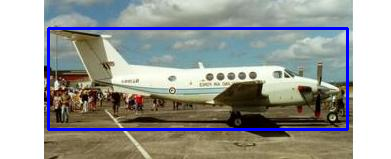

In [16]:
import cv2
from google.colab.patches import cv2_imshow

im = cv2.imread(test_file)

im = cv2.rectangle(im, (df.iloc[test_file_index][1], df.iloc[test_file_index][2]),	(df.iloc[test_file_index][3], df.iloc[test_file_index][4]), (255, 0, 0), 2)

cv2_imshow(im)

## Train

### Setup paths

In [17]:
# -----------------------------
#   IMPORTS
# -----------------------------
# Import the necessary packages
import os

# Define the base path to the input dataset and then use it to derive the path to the images directory
# and  the annotation CSV file
BASE_PATH = "/content/bounding-box-regression/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTATIONS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])

# Define the path to the base output directory
BASE_OUTPUT = "/content/bounding-box-regression/output"

# Define the path to the output serialized model, model training plot, and the testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

# Initialize our initial learning rate, number of epochs to train for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

### Import statements

In [18]:
# -----------------------------
#   USAGE
# -----------------------------
# python train.py

# -----------------------------
#   IMPORTS
# -----------------------------
# Import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

### Read annotations csv to get labels and file name

In [19]:
# Load the contents of the CVS annotations file
print("[INFO] Loading dataset...")
rows = open(ANNOTATIONS_PATH).read().strip().split("\n")

print(rows)

[INFO] Loading dataset...
['image_0001.jpg,49,30,349,137', 'image_0002.jpg,59,35,342,153', 'image_0003.jpg,47,36,331,135', 'image_0004.jpg,47,24,342,141', 'image_0005.jpg,48,18,339,146', 'image_0006.jpg,48,24,344,126', 'image_0007.jpg,49,23,344,122', 'image_0008.jpg,51,29,344,119', 'image_0009.jpg,50,29,344,137', 'image_0010.jpg,55,32,335,106', 'image_0011.jpg,58,35,344,130', 'image_0012.jpg,49,25,344,122', 'image_0013.jpg,48,31,344,146', 'image_0014.jpg,55,37,349,121', 'image_0015.jpg,61,39,353,163', 'image_0016.jpg,59,54,327,137', 'image_0017.jpg,62,37,347,143', 'image_0018.jpg,57,33,348,147', 'image_0019.jpg,51,33,341,146', 'image_0020.jpg,45,31,345,165', 'image_0021.jpg,48,28,347,129', 'image_0022.jpg,49,30,344,130', 'image_0023.jpg,50,23,341,121', 'image_0024.jpg,48,25,344,106', 'image_0025.jpg,56,31,342,140', 'image_0026.jpg,59,30,337,127', 'image_0027.jpg,53,25,348,123', 'image_0028.jpg,54,29,346,114', 'image_0029.jpg,56,29,348,119', 'image_0030.jpg,47,15,354,161', 'image_0031.j

## Load filenames, images and resize images for model, rescale labels. 

In [20]:
# Initialize the list of data (images), the target output predictions (bounding box coordinates),
# along with the filenames of the individual images
data = []
targets = []
filenames = []

# Loop over the rows
for row in rows:
    
    # Break the row into the filename and bounding box coordinates
    row = row.split(",")
    (filename, startX, startY, endX, endY) = row
    
    # Derive the path to the input image, load the image (in OpenCV format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]

    # Scale the bounding box coordinates relative to the spatial dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # Load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    
    # Update the list of data, targets and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)



## Normalize, convert to float32 and do train,test split

In [21]:
# Convert the data and targets to NumPy arrays, scaling the input pixel intensities, from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# Partition the data into training and testing splits using 90% of the data for training and 10% of the data for testing
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

print("TOTAL SPLIT:")
print(len(split))

print("\nTRAIN LABELS:")
print(split[2])
print(split[2].shape)
print("\nTEST LABELS:")
print(split[3])
print(split[3].shape)

print("\nTRAIN IMAGE NAMES:")
print(split[4])
print(len(split[4]))
print("\nTEST IMAGE NAMES:")
print(split[5])
print(len(split[5]))

TOTAL SPLIT:
6

TRAIN LABELS:
[[0.13868614 0.2184874  0.86618006 0.8067227 ]
 [0.10687023 0.21186441 0.8778626  0.80508476]
 [0.12244898 0.21582733 0.752551   0.79856116]
 ...
 [0.14492753 0.21290323 0.8285024  0.7935484 ]
 [0.1281407  0.21259843 0.8743719  0.81889766]
 [0.1164557  0.21052632 0.87848103 0.81954885]]
(720, 4)

TEST LABELS:
[[0.14       0.21232876 0.88       0.79452056]
 [0.13316584 0.20134228 0.8718593  0.81208056]
 [0.11734694 0.22023809 0.872449   0.8333333 ]
 [0.11989796 0.19008264 0.88265306 0.8264463 ]
 [0.11195929 0.1388889  0.8727735  0.8333333 ]
 [0.1610577  0.36363637 0.84615386 0.7151515 ]
 [0.13691932 0.19298245 0.8630807  0.80701756]
 [0.14786968 0.19393939 0.8671679  0.8       ]
 [0.11970074 0.203125   0.8703242  0.796875  ]
 [0.1037037  0.16541353 0.8691358  0.80451125]
 [0.13065326 0.26530612 0.8643216  0.7414966 ]
 [0.14215687 0.24183007 0.8382353  0.8039216 ]
 [0.13164558 0.21551724 0.8759494  0.80172414]
 [0.125      0.1734104  0.8647959  0.8323699 ]
 

### Load train, test split data

In [22]:
# Unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# Write the testing filenames to disk in order to use them when evaluating/testing the bounding box regression model
print("[INFO] Saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] Saving testing filenames...


### Create model

In [23]:
# Load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze all VGG layers so they will *not* be updated during the training process
vgg.trainable = False

# Flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# Construct a fully-connected layer header to output the predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# Construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

58892288/58889256 [==============================] - 1s 0us/step


### Model compile

In [24]:
# Initialize the optimizer, compile the model, and show the model summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Show model graph

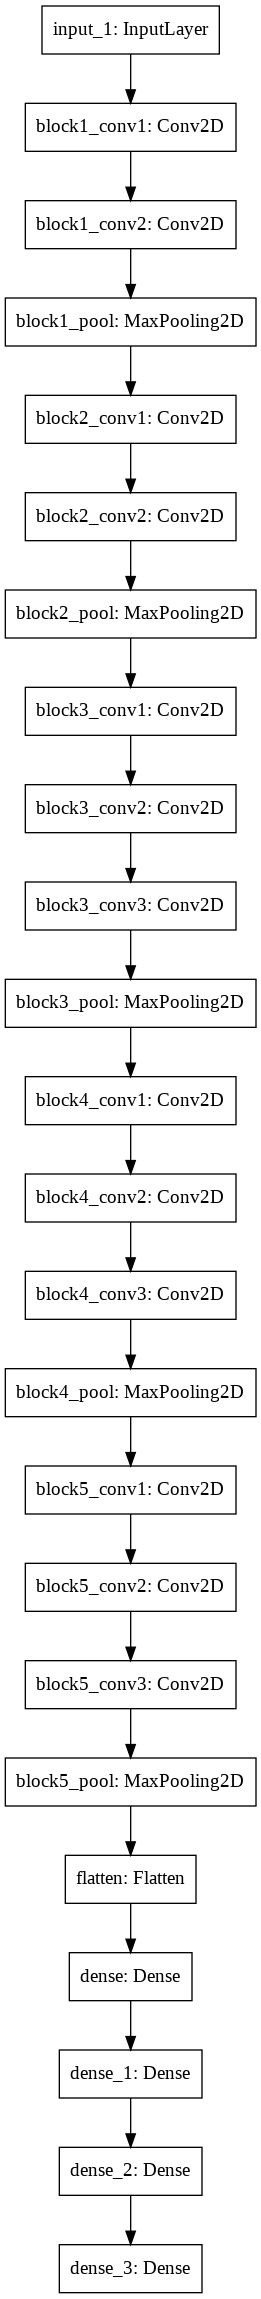

In [25]:
from tensorflow import keras
keras.utils.plot_model(model, "bbox_regression_model.png")

### Train model

In [26]:
# Train the network for bounding box regression
print("[INFO] Training the bounding box regression model...")
H = model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets),
              batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1)

[INFO] Training the bounding box regression model...
Epoch 1/25
23/23 [==============================] - 45s 290ms/step - loss: 0.0413 - val_loss: 0.0028
Epoch 2/25
23/23 [==============================] - 3s 133ms/step - loss: 0.0021 - val_loss: 7.4341e-04
Epoch 3/25
23/23 [==============================] - 3s 134ms/step - loss: 0.0011 - val_loss: 5.7961e-04
Epoch 4/25
23/23 [==============================] - 3s 134ms/step - loss: 8.5552e-04 - val_loss: 5.1867e-04
Epoch 5/25
23/23 [==============================] - 3s 134ms/step - loss: 6.0422e-04 - val_loss: 4.8826e-04
Epoch 6/25
23/23 [==============================] - 3s 134ms/step - loss: 7.3551e-04 - val_loss: 5.0947e-04
Epoch 7/25
23/23 [==============================] - 3s 136ms/step - loss: 5.3275e-04 - val_loss: 4.4012e-04
Epoch 8/25
23/23 [==============================] - 3s 136ms/step - loss: 4.7549e-04 - val_loss: 4.4274e-04
Epoch 9/25
23/23 [==============================] - 3s 137ms/step - loss: 5.2722e-04 - val_loss: 4

### Save model

In [27]:
# Serialize the model to disk
print("[INFO] Saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] Saving object detector model...


### Plot loss graph

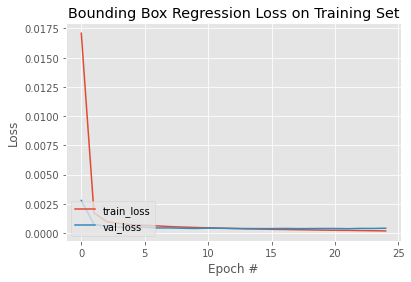

In [28]:
# Plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

## Predict

In [29]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

In [30]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg' -O '/content/bounding-box-regression/dataset/test/cat.jpg'

--2021-04-01 15:36:27--  https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2833605 (2.7M) [image/jpeg]
Saving to: ‘/content/bounding-box-regression/dataset/test/cat.jpg’

/content/bounding-b 100%[===================>]   2.70M  --.-KB/s    in 0.09s   

2021-04-01 15:36:27 (29.3 MB/s) - ‘/content/bounding-box-regression/dataset/test/cat.jpg’ saved [2833605/2833605]



In [31]:
import glob
file_list = glob.glob('/content/bounding-box-regression/dataset/test/*.jpg')
print(file_list)

['/content/bounding-box-regression/dataset/test/cat.jpg', '/content/bounding-box-regression/dataset/test/48764060802_f4d4f052a2_o.jpg', '/content/bounding-box-regression/dataset/test/GettyImages-1131335393-e1580493890249-scaled.jpg', '/content/bounding-box-regression/dataset/test/essay-on-aeroplane.jpg', '/content/bounding-box-regression/dataset/test/depositphotos_9213059-stock-photo-airplane.jpg', '/content/bounding-box-regression/dataset/test/photo-1529074963764-98f45c47344b.jpg']


(439, 960, 3)


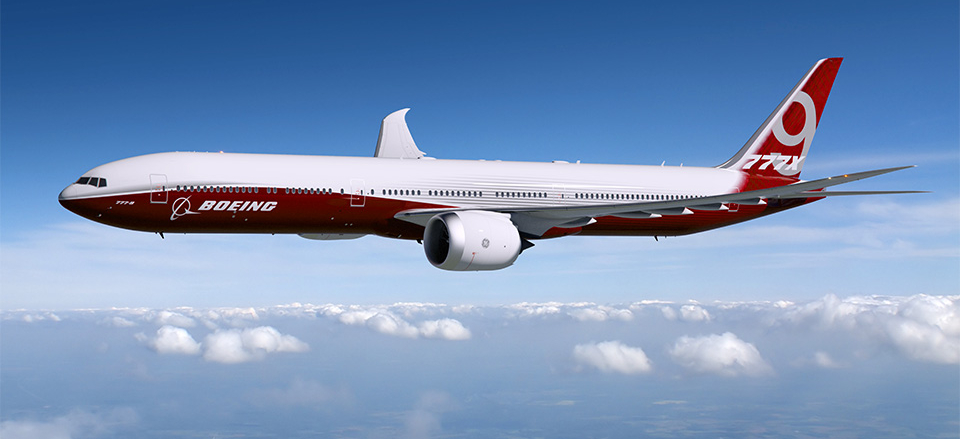

(274, 600, 3)


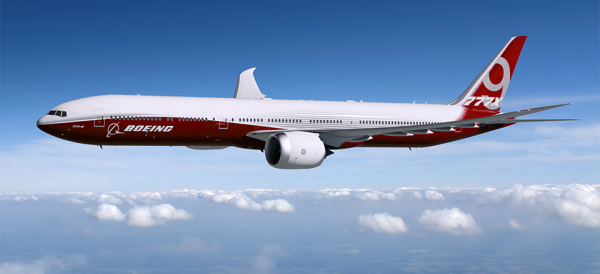

In [32]:
image = cv2.imread(file_list[1])
print(image.shape)
cv2_imshow(image)

image = imutils.resize(image, width=600)
print(image.shape)
cv2_imshow(image)

(224, 224, 3)
(1, 224, 224, 3)
[[0.18790534 0.18317296 0.8097967  0.75023335]]
(2397, 1795, 3)
(801, 600, 3)


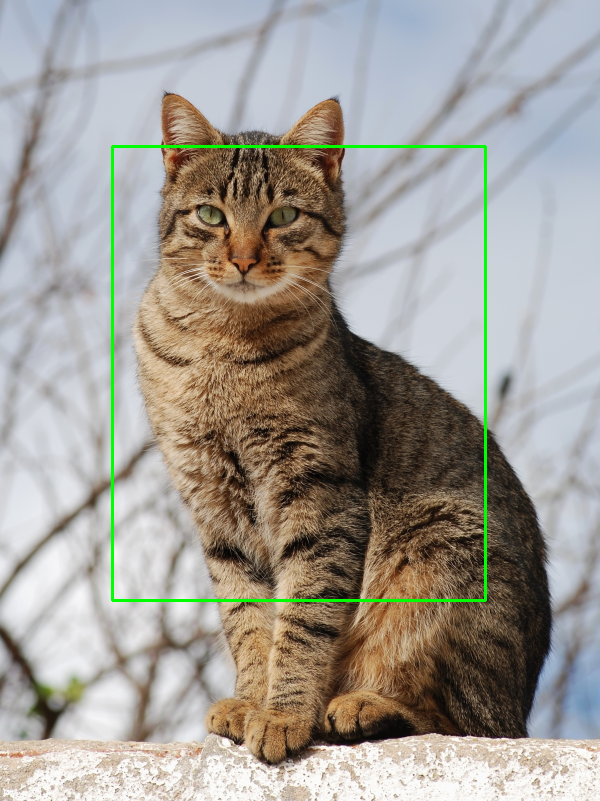

(224, 224, 3)
(1, 224, 224, 3)
[[0.18594705 0.17767152 0.8420881  0.74416727]]
(439, 960, 3)
(274, 600, 3)


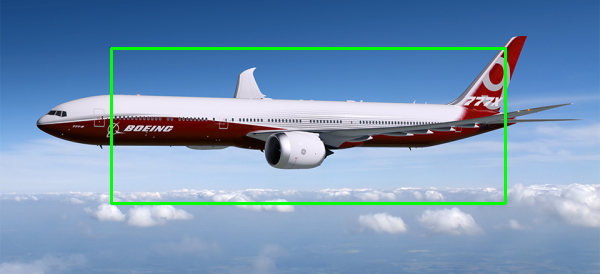

(224, 224, 3)
(1, 224, 224, 3)
[[0.17761193 0.29159522 0.82267034 0.7282716 ]]
(1709, 2560, 3)
(400, 600, 3)


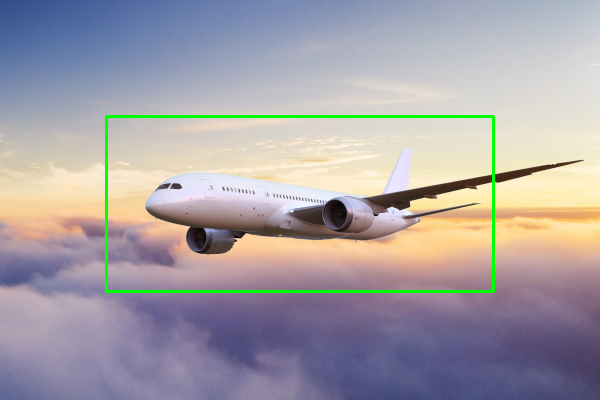

(224, 224, 3)
(1, 224, 224, 3)
[[0.12775995 0.26184422 0.8832438  0.7684527 ]]
(281, 500, 3)
(337, 600, 3)


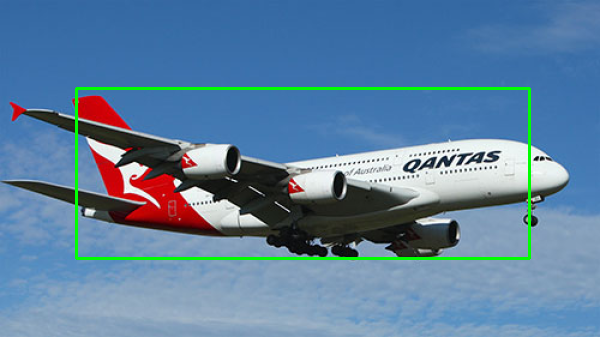

(224, 224, 3)
(1, 224, 224, 3)
[[0.13530524 0.23870893 0.86451745 0.7524889 ]]
(348, 600, 3)
(348, 600, 3)


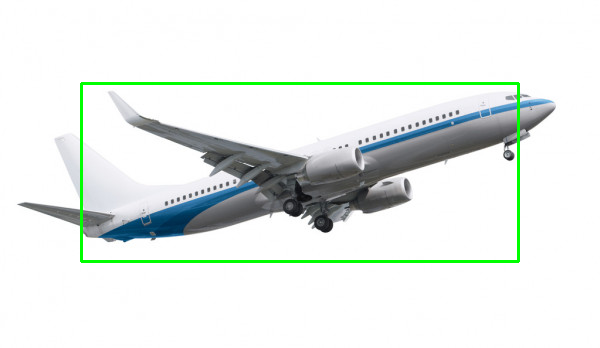

(224, 224, 3)
(1, 224, 224, 3)
[[0.1584797  0.2743329  0.853493   0.72581345]]
(655, 1000, 3)
(393, 600, 3)


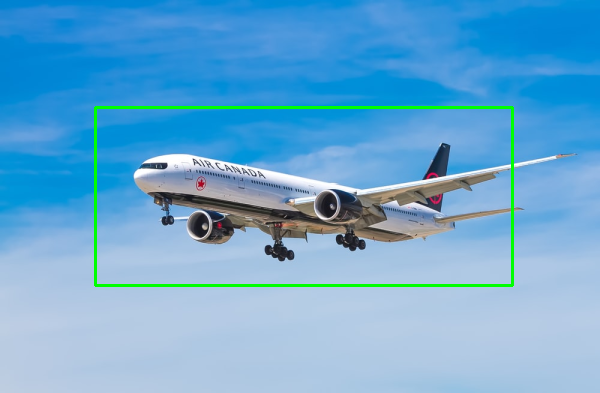

In [33]:
model = load_model(MODEL_PATH)

# Loop over the image that are going to be used for testing the bounding box regression model
for imagePath in file_list:
  
  # Load the input image (in Keras format) from disk and preprocess it, scaling pixel intensities to the range [0,1]
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  print(image.shape)
  image = np.expand_dims(image, axis=0)
  print(image.shape)
  # Make the bounding box predictions on the input image
  preds = model.predict(image)[0]
  print(model.predict(image))
  (startX, startY, endX, endY) = preds
  
  # Load the input image (in OpenCV format), resize it such that it fits in the screen and grab its dimensions
  image = cv2.imread(imagePath)
  print(image.shape)
  
  # Resize all images to same shape keeping aspect ratio so all images take equal space
  image = imutils.resize(image, width=600)
  print(image.shape)
  
  (h, w) = image.shape[:2]
  # Scale the predicted bounding box coordinates based on the image dimensions
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  # Draw the predicted image bounding box on the image
  cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
  # Show the output image
  cv2_imshow(image)
  #cv2.waitKey(0)


# Multiclass classification and bounding box regression

## Copy and extract dataset

In [2]:
!cp -r "/content/drive/MyDrive/ML zantrik/Object_Detection_Research/multi-class-bbox-regression/multi-class-bbox-regression.zip" "/content/"

In [3]:
!unzip multi-class-bbox-regression.zip

Archive:  multi-class-bbox-regression.zip
   creating: multi-class-bbox-regression/
   creating: multi-class-bbox-regression/pyimagesearch/
 extracting: multi-class-bbox-regression/pyimagesearch/__init__.py  
 extracting: multi-class-bbox-regression/pyimagesearch/config.py  
   creating: multi-class-bbox-regression/output/
   creating: multi-class-bbox-regression/output/plots/
 extracting: multi-class-bbox-regression/output/plots/losses.png  
 extracting: multi-class-bbox-regression/output/plots/accuracies.png  
   creating: multi-class-bbox-regression/dataset/
   creating: multi-class-bbox-regression/dataset/images/
   creating: multi-class-bbox-regression/dataset/images/motorcycle/
 extracting: multi-class-bbox-regression/dataset/images/motorcycle/image_0028.jpg  
 extracting: multi-class-bbox-regression/dataset/images/motorcycle/image_0031.jpg  
 extracting: multi-class-bbox-regression/dataset/images/motorcycle/image_0005.jpg  
 extracting: multi-class-bbox-regression/dataset/images

## Fix not downloaded csv file

**Use this incase the downloaded csv file is not correct.**

In [4]:
%cd "/content/multi-class-bbox-regression/dataset"

/content/multi-class-bbox-regression/dataset


In [5]:
!rm -r "/content/multi-class-bbox-regression/dataset/annotations"

In [6]:
!cp "/content/drive/MyDrive/ML zantrik/Object_Detection_Research/multi-class-bbox-regression/annotations.zip" "/content/multi-class-bbox-regression/dataset/"

In [7]:
!unzip "annotations.zip"

Archive:  annotations.zip
   creating: Annotations/
  inflating: Annotations/airplane.csv  
  inflating: Annotations/face.csv    
  inflating: Annotations/motorcycle.csv  


In [ ]:
#!rm "annotations.zip"

## Get test data

In [8]:
test_path = "/content/multi-class-bbox-regression/dataset/test"

In [9]:
!mkdir "$test_path"

In [10]:
!wget "https://www.aurumbureau.com/wp-content/uploads/2020/11/Aurum-Speakers-Bureau-Andrew-Ng.jpg" -O "$test_path/face1.jpg"
!wget "https://www.actuia.com/wp-content/uploads/2018/04/Yann-LeCun-Entrupy-Technical-Advisor.jpg" -O "$test_path/face2.jpg"

!wget "https://secure.i.telegraph.co.uk/multimedia/archive/03023/280907-a-bmw_mb_3023438k.jpg" -O "$test_path/bike1.jpg"
!wget "https://www.setaswall.com/wp-content/uploads/2017/06/Motorbike-Wallpapers-20-1680-x-1050.jpg" -O "$test_path/bike2.jpg"

!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/N17503_(10970972864).jpg/1200px-N17503_(10970972864).jpg" -O "$test_path/plane1.jpg"
!wget "http://3.bp.blogspot.com/-10qKB9Iqy8g/TmtE3VnV8GI/AAAAAAAAFx4/hRK8HOtjVbk/s1600/airplane%252Bpics+3.jpg" -O "$test_path/plane2.jpg"

--2021-04-01 16:49:37--  https://www.aurumbureau.com/wp-content/uploads/2020/11/Aurum-Speakers-Bureau-Andrew-Ng.jpg
Resolving www.aurumbureau.com (www.aurumbureau.com)... 35.206.119.224
Connecting to www.aurumbureau.com (www.aurumbureau.com)|35.206.119.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30072 (29K) [image/jpeg]
Saving to: ‘/content/multi-class-bbox-regression/dataset/test/face1.jpg’

/content/multi-clas 100%[===================>]  29.37K  --.-KB/s    in 0s      

2021-04-01 16:49:37 (69.1 MB/s) - ‘/content/multi-class-bbox-regression/dataset/test/face1.jpg’ saved [30072/30072]

--2021-04-01 16:49:37--  https://www.actuia.com/wp-content/uploads/2018/04/Yann-LeCun-Entrupy-Technical-Advisor.jpg
Resolving www.actuia.com (www.actuia.com)... 51.178.61.80
Connecting to www.actuia.com (www.actuia.com)|51.178.61.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58609 (57K) [image/jpeg]
Saving to: ‘/content/multi-class-bbox-re

## Read label files

In [45]:
import pandas as pd
df_plane = pd.read_csv('/content/multi-class-bbox-regression/dataset/annotations/airplane.csv', header=None)

In [46]:
df_plane.head(10)

0   1   2    3    4         5
0  image_0001.jpg  49  30  349  137  airplane
1  image_0002.jpg  59  35  342  153  airplane
2  image_0003.jpg  47  36  331  135  airplane
3  image_0004.jpg  47  24  342  141  airplane
4  image_0005.jpg  48  18  339  146  airplane
5  image_0006.jpg  48  24  344  126  airplane
6  image_0007.jpg  49  23  344  122  airplane
7  image_0008.jpg  51  29  344  119  airplane
8  image_0009.jpg  50  29  344  137  airplane
9  image_0010.jpg  55  32  335  106  airplane

In [47]:
import pandas as pd
df_face = pd.read_csv('/content/multi-class-bbox-regression/dataset/annotations/face.csv', header=None)

In [48]:
df_face.head(10)

0    1   2    3    4     5
0  image_0001.jpg  251  15  444  300  face
1  image_0002.jpg  106  31  296  310  face
2  image_0003.jpg  207  17  385  279  face
3  image_0004.jpg  102  55  303  328  face
4  image_0005.jpg  246  30  446  312  face
5  image_0006.jpg  248  22  440  298  face
6  image_0007.jpg  173  25  365  302  face
7  image_0008.jpg  227  47  429  333  face
8  image_0009.jpg  116  27  299  303  face
9  image_0010.jpg  121  34  314  302  face

In [49]:
import pandas as pd
df_bike = pd.read_csv('/content/multi-class-bbox-regression/dataset/annotations/motorcycle.csv', header=None)

In [50]:
df_bike.head(10)

0   1   2    3    4           5
0  image_0001.jpg  31  19  233  141  motorcycle
1  image_0002.jpg  32  15  232  142  motorcycle
2  image_0003.jpg  30  20  234  143  motorcycle
3  image_0004.jpg  30  15  231  132  motorcycle
4  image_0005.jpg  31  19  232  145  motorcycle
5  image_0006.jpg  32  20  231  142  motorcycle
6  image_0007.jpg  33  16  230  121  motorcycle
7  image_0008.jpg  31  17  232  125  motorcycle
8  image_0009.jpg  31  18  231  133  motorcycle
9  image_0010.jpg  32  18  233  127  motorcycle

In [51]:
print(df_plane.iloc[0])

0    image_0001.jpg
1                49
2                30
3               349
4               137
5          airplane
Name: 0, dtype: object


In [52]:
print(df_plane.iloc[0][0])

image_0001.jpg


## Fix issues of certain images not downloaded but exists in csv

In [110]:
import glob
image_list_plane = glob.glob('/content/multi-class-bbox-regression/dataset/images/airplane/*.jpg')
image_list_face = glob.glob('/content/multi-class-bbox-regression/dataset/images/face/*.jpg')
image_list_bike = glob.glob('/content/multi-class-bbox-regression/dataset/images/motorcycle/*.jpg')

In [111]:
print(image_list_plane)
print(len(image_list_plane))

print(image_list_face)
print(len(image_list_face))

print(image_list_bike)
print(len(image_list_bike))

['/content/multi-class-bbox-regression/dataset/images/airplane/image_0331.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0489.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0527.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0771.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0736.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0587.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0698.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0493.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0211.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0398.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0321.jpg', '/content/multi-class-bbox-regression/dataset/images/airplane/image_0034.jpg', '/content/multi-class-bbox-regression/dataset/image

In [112]:
image_list_plane_basename = [os.path.basename(name) for name in image_list_plane]
print(image_list_plane_basename)

image_list_face_basename = [os.path.basename(name) for name in image_list_face]
print(image_list_face_basename)

image_list_bike_basename = [os.path.basename(name) for name in image_list_bike]
print(image_list_bike_basename)

['image_0331.jpg', 'image_0489.jpg', 'image_0527.jpg', 'image_0771.jpg', 'image_0736.jpg', 'image_0587.jpg', 'image_0698.jpg', 'image_0493.jpg', 'image_0211.jpg', 'image_0398.jpg', 'image_0321.jpg', 'image_0034.jpg', 'image_0361.jpg', 'image_0732.jpg', 'image_0153.jpg', 'image_0752.jpg', 'image_0127.jpg', 'image_0294.jpg', 'image_0424.jpg', 'image_0105.jpg', 'image_0329.jpg', 'image_0011.jpg', 'image_0218.jpg', 'image_0001.jpg', 'image_0570.jpg', 'image_0735.jpg', 'image_0465.jpg', 'image_0200.jpg', 'image_0522.jpg', 'image_0486.jpg', 'image_0356.jpg', 'image_0718.jpg', 'image_0272.jpg', 'image_0549.jpg', 'image_0774.jpg', 'image_0764.jpg', 'image_0726.jpg', 'image_0053.jpg', 'image_0176.jpg', 'image_0653.jpg', 'image_0229.jpg', 'image_0251.jpg', 'image_0470.jpg', 'image_0778.jpg', 'image_0481.jpg', 'image_0548.jpg', 'image_0345.jpg', 'image_0084.jpg', 'image_0623.jpg', 'image_0765.jpg', 'image_0338.jpg', 'image_0430.jpg', 'image_0637.jpg', 'image_0501.jpg', 'image_0142.jpg', 'image_06

In [ ]:
# TODO: Drop rows from data frame for which no image exists


## Show an example from each train class

In [53]:
test_file_index = 22
test_file = '/content/multi-class-bbox-regression/dataset/images/airplane/' + df_plane.iloc[test_file_index][0]

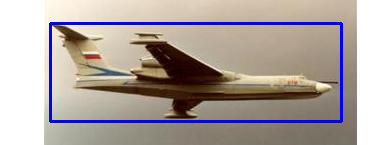

In [54]:
import cv2
from google.colab.patches import cv2_imshow

im = cv2.imread(test_file)

im = cv2.rectangle(im, (df_plane.iloc[test_file_index][1], df_plane.iloc[test_file_index][2]),	(df_plane.iloc[test_file_index][3], df_plane.iloc[test_file_index][4]), (255, 0, 0), 2)

cv2_imshow(im)

In [55]:
test_file_index = 14
test_file = '/content/multi-class-bbox-regression/dataset/images/face/' + df_face.iloc[test_file_index][0]

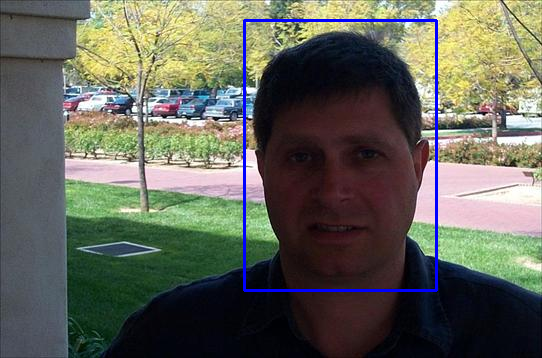

In [56]:
import cv2
from google.colab.patches import cv2_imshow

im = cv2.imread(test_file)

im = cv2.rectangle(im, (df_face.iloc[test_file_index][1], df_face.iloc[test_file_index][2]),	(df_face.iloc[test_file_index][3], df_face.iloc[test_file_index][4]), (255, 0, 0), 2)

cv2_imshow(im)

In [57]:
test_file_index = 4

test_file = '/content/multi-class-bbox-regression/dataset/images/motorcycle/' + df_bike.iloc[test_file_index][0]

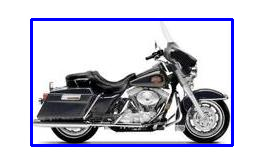

In [58]:
import cv2
from google.colab.patches import cv2_imshow

im = cv2.imread(test_file)

im = cv2.rectangle(im, (df_bike.iloc[test_file_index][1], df_bike.iloc[test_file_index][2]),	(df_bike.iloc[test_file_index][3], df_bike.iloc[test_file_index][4]), (255, 0, 0), 2)

cv2_imshow(im)

## Train

### Set path and hyperparameters

In [59]:
# -----------------------------
#   IMPORTS
# -----------------------------
# Import the necessary packages
import os

# Define the base path to the input dataset and then use it to derive the path to the input images and annotation files
BASE_PATH = "/content/multi-class-bbox-regression/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTATIONS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

# Define the path to the base output directory
BASE_OUTPUT = "/content/multi-class-bbox-regression/output"

# Define the path to the output model, label binarizer, plots output directory and the testing image paths
MODEL_PATH = os.path.sep.join([BASE_PATH, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_PATH, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

# Initialize the initial learning rate, number of epochs to train for and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32


### imports

In [60]:
# -----------------------------
#   USAGE
# -----------------------------
# python train.py

# -----------------------------
#   IMPORTS
# -----------------------------
# Import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os



### Load and format image, bbox coordinates, labels, filepaths

In [61]:

# Initialize the list of data (images), class labels, target bounding box coordinates and image paths
print("[INFO] Loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

# Loop over all CSV files in the annotations directory
for csvPath in paths.list_files(ANNOTATIONS_PATH, validExts=".csv"):


    # Load the contents of the current CSV annotation file
    rows = open(csvPath).read().strip().split("\n")

    # Loop over the rows
    for row in rows:

        # Break the row into the filename, bounding box coordinates and class label
        row = row.split(",")
        (filename, startX, startY, endX, endY, label) = row

        # Derive the path to the input image, load the image (in OpenCV format) and grab its dimensions
        imagePath = os.path.sep.join([IMAGES_PATH, label, filename])
        image = cv2.imread(imagePath)
        (h, w) = image.shape[:2]

        # Scale the bounding box coordinates relative to the spatial dimensions of the input image
        startX = float(startX)/w
        startY = float(startY)/h
        endX = float(endX)/w
        endY = float(endY)/h

        # Load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        
        # Update the list of data, class labels, bounding boxes and image paths
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

[INFO] Loading dataset...


### Rescale and convert bbox to float

In [62]:

# Convert the data, class labels, bounding boxes and image paths to NumPy arrays, scaling the input pixel intensities
# from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32")/255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

In [109]:
print(len(data))
print(len(labels))
print(len(imagePaths))

2033
2033
2033


### One hot encode labels

In [63]:
# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# If there are only two labels in the dataset, use Keras/Tensorflow's utility function as well
if len(lb.classes_) == 2:
    labels = to_categorical(labels)

In [114]:
print(labels)
print(labels.shape)

[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]
(2033, 3)


### Split data for training and validation

In [64]:
# Partition the data into training and testing splits using 80% of the data for training and 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)

### Assign splits to variables

In [65]:

# Unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

### Save test txt file

In [66]:
# Write the testing image paths to disk in order to use them when evaluating/testing the object detector
print("[INFO] Saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] Saving testing image paths...


### Create classification and regression model

In [67]:
# Load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze all VOG layers so they will not be updated during the training process
vgg.trainable = False

# Flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# Construct the fully-connected layer header to the output predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# Construct the second fully-connected layer head and use this one to predict the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# Put together the model which accept an input image and then output the bounding box coordinates and the class label
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))



58892288/58889256 [==============================] - 1s 0us/step


### Setup loss, optimizer and metrics

In [68]:
# Define the dictionary to set the loss methods -- categorical cross-entropy for the class label head and mean absolute
# error for the bounding box head
losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"}

# Initialize the optimizer, compile the model and show the model summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

### Show model graph

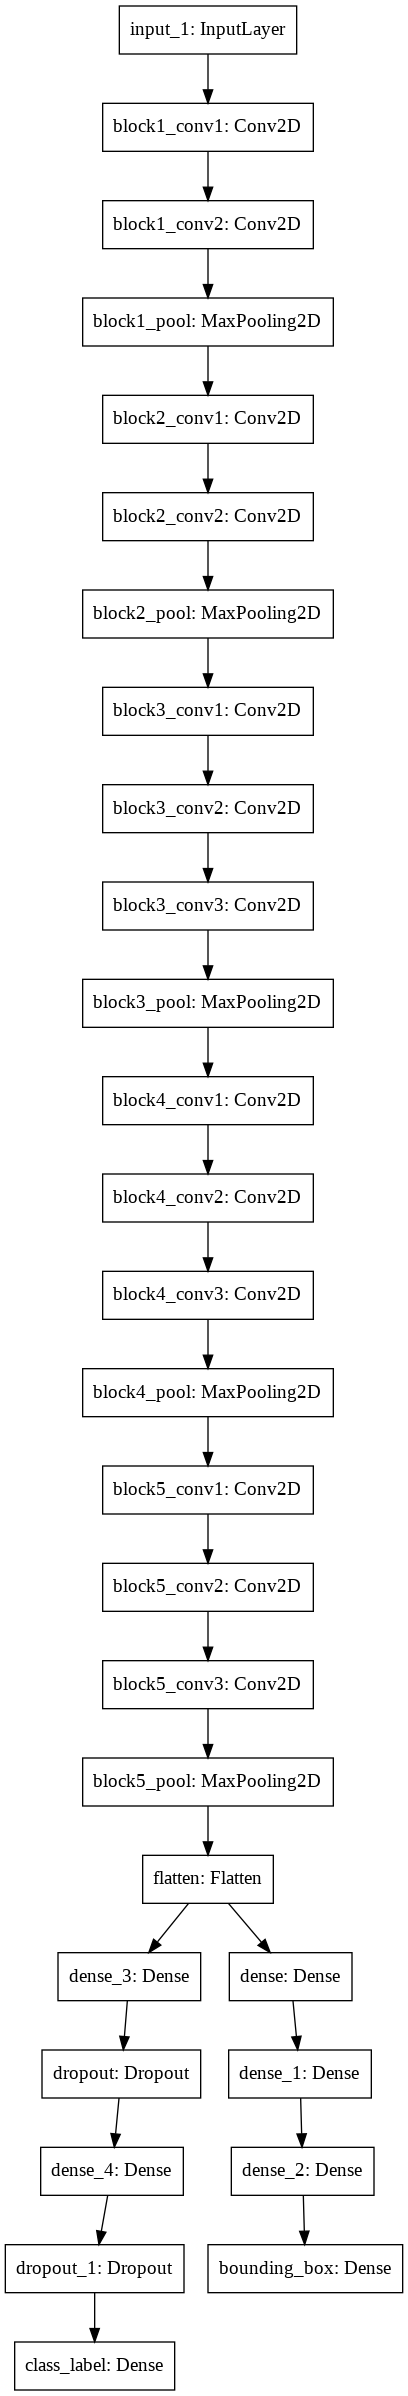

In [69]:
from tensorflow import keras
keras.utils.plot_model(model, "classification_and_bbox_regression.png")

### Combine labels/annotations for training

In [70]:
# Construct the dictionary for the target training outputs
trainTargets = {"class_label": trainLabels, "bounding_box": trainBBoxes}

# Construct the second dictionary, for target testing outputs
testTargets = {"class_label": testLabels, "bounding_box": testBBoxes}

### Train model

In [71]:
# Train the network for the bounding box regression and class label prediction
print("[INFO] Training model...")
H = model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS, verbose=1)

[INFO] Training model...
Epoch 1/20
51/51 [==============================] - 56s 350ms/step - loss: 0.1168 - bounding_box_loss: 0.0285 - class_label_loss: 0.0883 - bounding_box_accuracy: 0.7063 - class_label_accuracy: 0.8019 - val_loss: 0.0022 - val_bounding_box_loss: 0.0021 - val_class_label_loss: 1.0709e-04 - val_bounding_box_accuracy: 0.8231 - val_class_label_accuracy: 1.0000
Epoch 2/20
51/51 [==============================] - 8s 158ms/step - loss: 0.0048 - bounding_box_loss: 0.0015 - class_label_loss: 0.0033 - bounding_box_accuracy: 0.8453 - class_label_accuracy: 0.9959 - val_loss: 0.0016 - val_bounding_box_loss: 0.0016 - val_class_label_loss: 6.5948e-05 - val_bounding_box_accuracy: 0.8894 - val_class_label_accuracy: 1.0000
Epoch 3/20
51/51 [==============================] - 8s 160ms/step - loss: 0.0023 - bounding_box_loss: 9.4520e-04 - class_label_loss: 0.0013 - bounding_box_accuracy: 0.8791 - class_label_accuracy: 0.9993 - val_loss: 0.0017 - val_bounding_box_loss: 0.0014 - val_cl

### Save model

In [72]:
# Serialize the model to disk
print("[INFO] Saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] Saving object detector model...


### Save labels

In [73]:
# Serialize the label binarizer to disk
print("[INFO] Saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] Saving label binarizer...


### Plot accuracy and losses

In [90]:
# Plot the total loss, label loss and the bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# Loop over the loss names
for (i, l) in enumerate(lossNames):
    # Plot the loss for both the training and the validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

# Save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
plt.close()


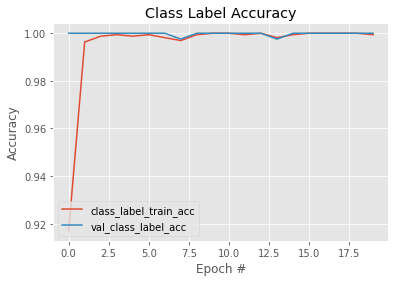

In [91]:
# Create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"], label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"], label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# Save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "accuracies.png"])
plt.savefig(plotPath)

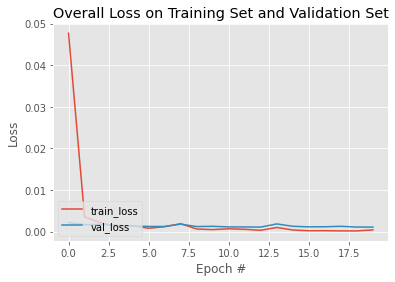

In [92]:
# Plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Overall Loss on Training Set and Validation Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

# Save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "losses1.png"])
plt.savefig(plotPath)

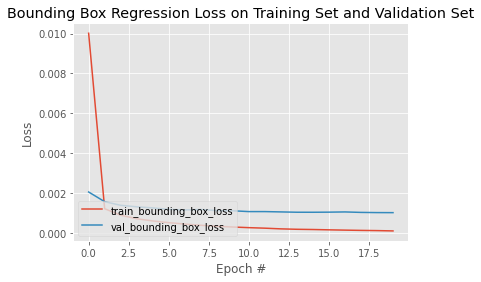

In [93]:
# Plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["bounding_box_loss"], label="train_bounding_box_loss")
plt.plot(np.arange(0, N), H.history["val_bounding_box_loss"], label="val_bounding_box_loss")
plt.title("Bounding Box Regression Loss on Training Set and Validation Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

# Save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "losses2.png"])
plt.savefig(plotPath)

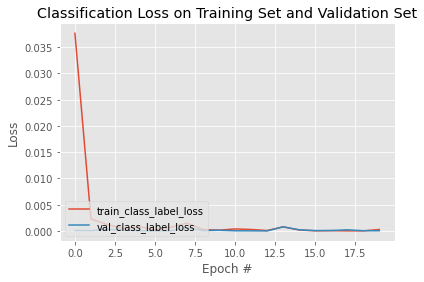

In [94]:
# Plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["class_label_loss"], label="train_class_label_loss")
plt.plot(np.arange(0, N), H.history["val_class_label_loss"], label="val_class_label_loss")
plt.title("Classification Loss on Training Set and Validation Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

# Save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "losses3.png"])
plt.savefig(plotPath)

## Predict

In [95]:
# -----------------------------------------------
#   USAGE
# -----------------------------------------------
# python predict.py --input output/test_paths.txt

# -----------------------------
#   IMPORTS
# -----------------------------
# Import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os

In [96]:
# Load the object detector and the label binarizer from disk
print("[INFO] Loading object detector...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())


[INFO] Loading object detector...


In [104]:
print(lb.classes_)

['airplane' 'face' 'motorcycle']


### Show a sample test file

In [97]:
import glob
file_list = glob.glob('/content/multi-class-bbox-regression/dataset/test/*.jpg')
print(file_list)

['/content/multi-class-bbox-regression/dataset/test/face1.jpg', '/content/multi-class-bbox-regression/dataset/test/plane1.jpg', '/content/multi-class-bbox-regression/dataset/test/plane2.jpg', '/content/multi-class-bbox-regression/dataset/test/bike1.jpg', '/content/multi-class-bbox-regression/dataset/test/bike2.jpg', '/content/multi-class-bbox-regression/dataset/test/face2.jpg']


(900, 1200, 3)


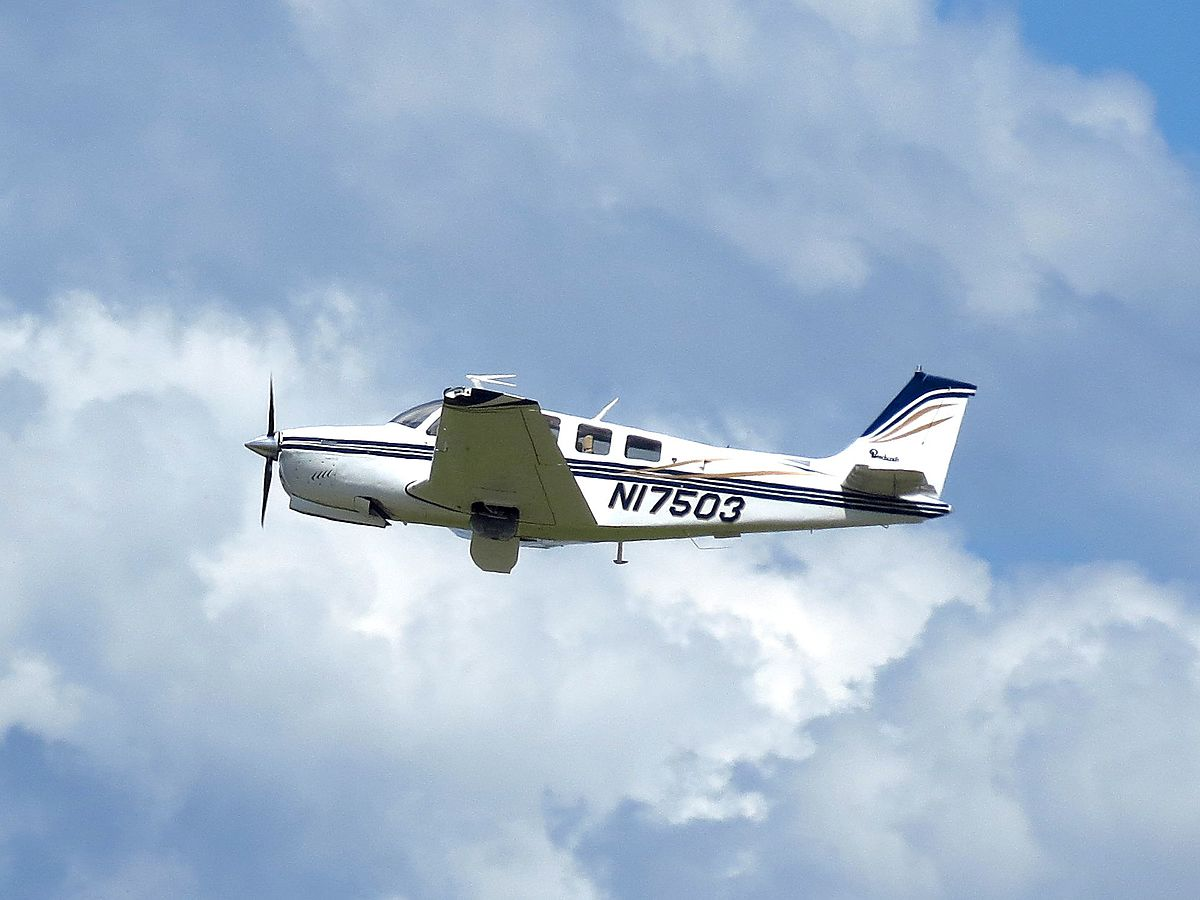

(450, 600, 3)


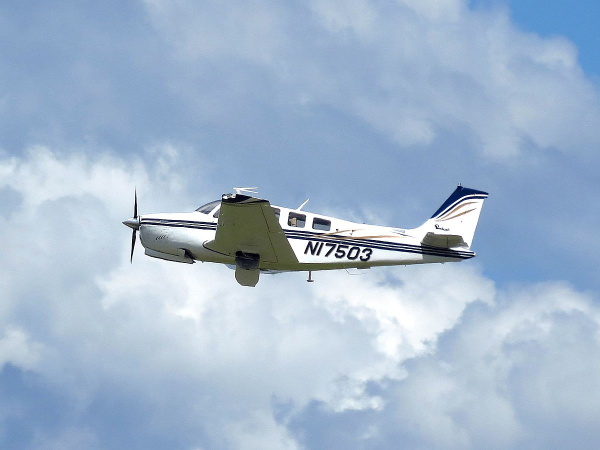

In [98]:
image = cv2.imread(file_list[1])
print(image.shape)
cv2_imshow(image)

image = imutils.resize(image, width=600)
print(image.shape)
cv2_imshow(image)

### Do inference

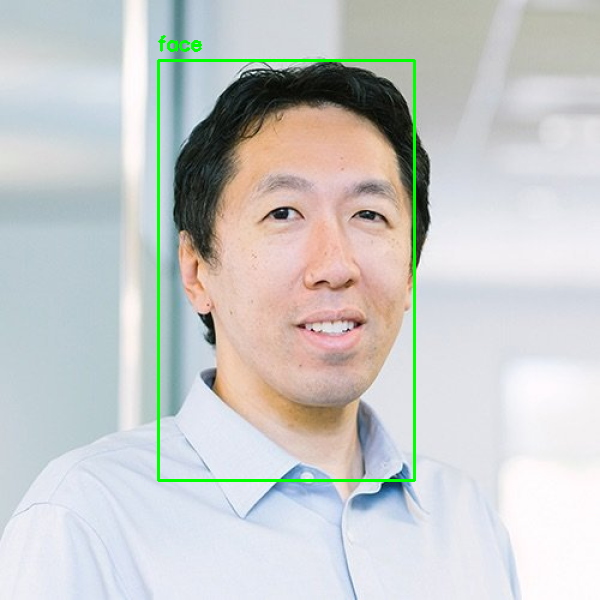

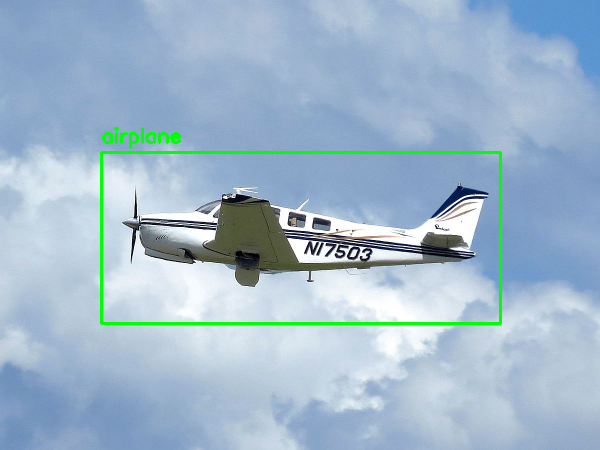

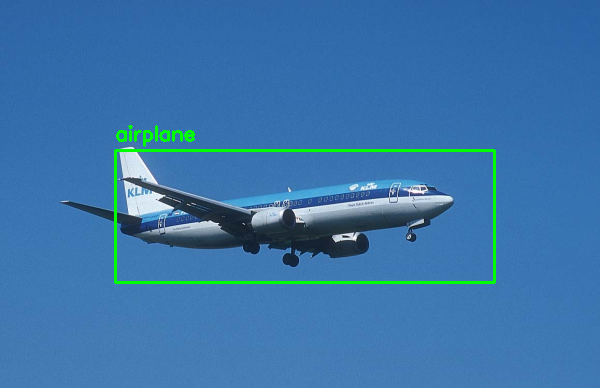

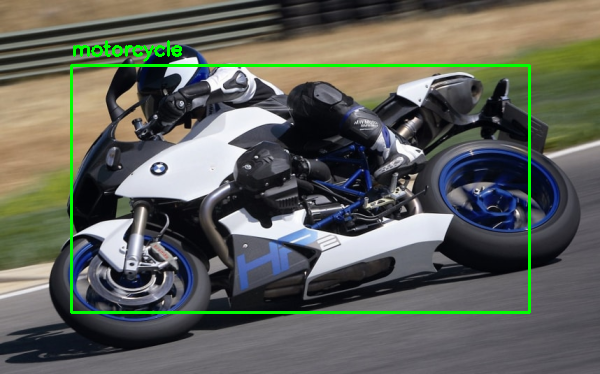

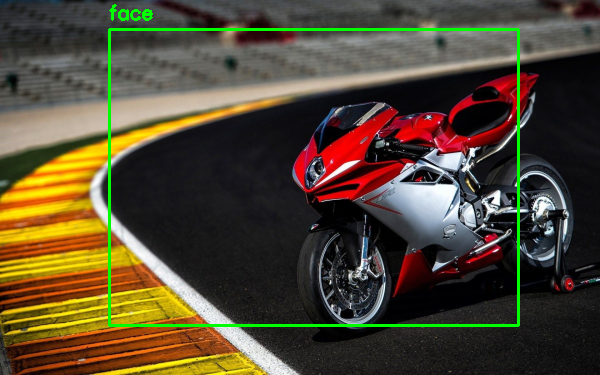

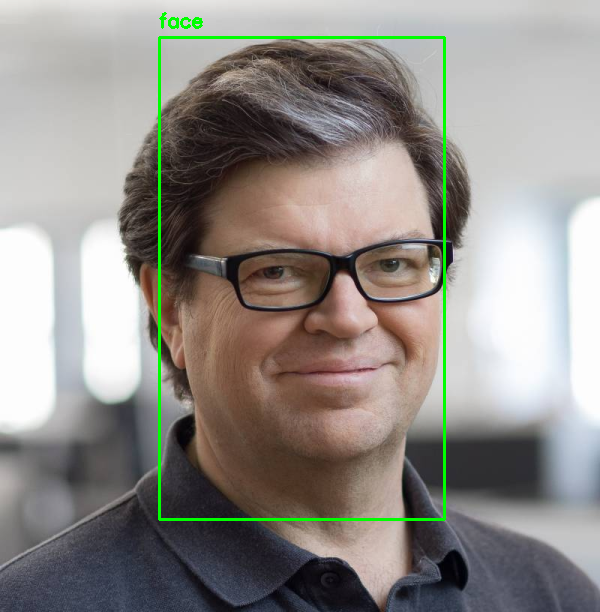

In [99]:
# Loop over the image that are going to be used for testing the bounding box regression model
for imagePath in file_list:
    
    # Load the input image (in keras format) from disk and preprocess it, scaling the pixel intensities to range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    
    # Predict the bounding box of the object along with the class label
    (boxPreds, labelPreds) = model.predict(image)
    (startX, startY, endX, endY) = boxPreds[0]
    
    # Determine the class label with the largest predicted probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]
    
    # Load the input image (in OpenCV format), resize it such that it fits the screen and grab its dimensions
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    
    # Scale the predicted bounding box coordinates based on the image dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    
    # Draw the predicted bounding boxes and class labels on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    
    # Show the output image
    cv2_imshow(image)
    #cv2.imshow("Output", image)
    #cv2.waitKey(0)

